In [1]:
import os
import sys

import numpy  as np
import tables as tb
import pandas as pd
import matplotlib
import math

#the line below makes the plot as a pop-up, that can be saved
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from scipy.stats import norm
from scipy.stats import exponnorm
from scipy.stats import skewnorm

import scipy.spatial.distance as scidist

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.core.exceptions import NoHits

In [2]:
import functions.histo_functions as myhf
import functions.efficiency_functions as myef
import functions.recovstrue as myrvt

In [3]:
#Dimensions for the NEXT100 detector
veto_N100 = 20 # mm
rmax_N100 = 492 - veto_N100
zmin_N100 = veto_N100
zmax_N100 = 1205 - veto_N100

In [4]:
filepath = '/Users/halmamol/NEXT/files/NEXT100/beershebaFS/'
max0nubbf = 999
maxselectron = 999
blobR = 21

## Opening TRACK Files - 0nubb

In [5]:
#0nubb files
track_list_0nubb = []

filepath_0nubb_tracks = filepath+f'0nubb/tracks/{blobR}mm/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb = filepath_0nubb_tracks+f'next100.0nubb.{nfile}.skel_tracks.R{blobR}mm_tb.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks = pd.read_hdf(filename_0nubb, 'Tracks')
    except:
        print('File {} not good'.format(filename_0nubb))
        continue
        
    track_list_0nubb.append(readfile_tracks)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_0nubb = pd.concat([dt for dt in track_list_0nubb]) 
tracks_0nubb.columns  

#these are all the elements inside the file:

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

In [6]:
#same for selectron files
track_list_selectron = []
filepath_selectron_tracks = filepath+f'/e-_roi/tracks/{blobR}mm/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,maxselectron):
    
    filename_selectron = filepath_selectron_tracks+f'next100.e-_roi.{nfile}.skel_tracks.R{blobR}mm_tb.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks_selectron = pd.read_hdf(filename_selectron, 'Tracks')
    except:
        print('File {} not good'.format(filename_selectron))
        continue
        
    track_list_selectron.append(readfile_tracks_selectron)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_selectron = pd.concat([dt for dt in track_list_selectron]) 
tracks_selectron.columns  

#these are all the elements inside the file:

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

## Checking cuts

interested in selecting the events in/with:
- **Fiducial**: fiducial cut around the detector volume, of 2cm from the border
- **1Track**: in this case, considers the track with highest deposition
- **NoOverlap**: defined blobs in one trace should not overlap
- **ROI**: energy cut in the region of interest, between [2.445,2475]MeV

In [7]:
#Checking total amount of events, prior any selection
nevents_0nubb_total = tracks_0nubb.event.nunique()
Enevents_0nubb_total = np.sqrt(nevents_0nubb_total)
print(f'Initial amount of events for 0nubb: {nevents_0nubb_total} +- {Enevents_0nubb_total}')

nevents_selectron_total = tracks_selectron.event.nunique()
Enevents_selectron_total = np.sqrt(nevents_selectron_total)
print(f'Initial amount of events for selectrons: {nevents_selectron_total} +- {Enevents_selectron_total}')

Initial amount of events for 0nubb: 9799 +- 98.98989847454133
Initial amount of events for selectrons: 9767 +- 98.82813364624468


### 1 - FIDUCIAL CUT

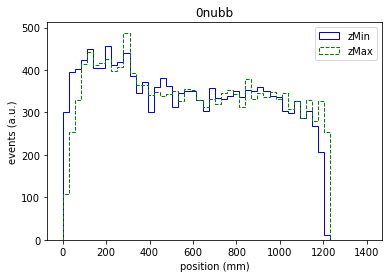

In [8]:
track_0nubb_zmin = tracks_0nubb.z_min
track_0nubb_zmax = tracks_0nubb.z_max

plt.hist(track_0nubb_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_0nubb_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

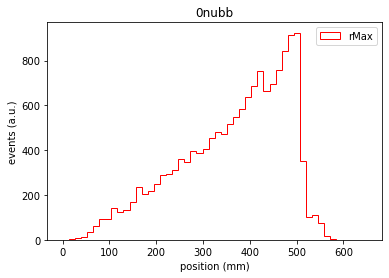

In [9]:
track_0nubb_rmax = tracks_0nubb.r_max

plt.hist(track_0nubb_rmax, bins = 50, range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

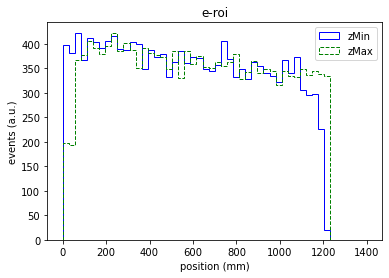

In [10]:
track_selectron_zmin = tracks_selectron.z_min
track_selectron_zmax = tracks_selectron.z_max

plt.hist(track_selectron_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_selectron_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()

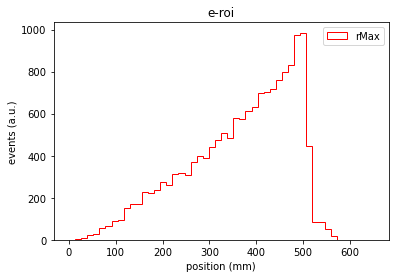

In [11]:
track_selectron_rmax = tracks_selectron.r_max

plt.hist(track_selectron_rmax, bins = 50,  range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()

In [12]:
print(f'MAX VALUE')
print(f'0nubb')
print(f'- Rmax = {np.amax(track_0nubb_rmax)}')
print(f'- Zmin = {np.amax(track_0nubb_zmin)}')
print(f'- Zmax = {np.amax(track_0nubb_zmax)}')
print(f'e-roi')
print(f'- Rmax = {np.amax(track_selectron_rmax)}')
print(f'- Zmin = {np.amax(track_selectron_zmin)}')
print(f'- Zmax = {np.amax(track_selectron_zmax)}')
print(f'AVG VALUE')
print(f'0nubb')
print(f'- Rmax = {np.average(track_0nubb_rmax)}')
print(f'- Zmin = {np.average(track_0nubb_zmin)}')
print(f'- Zmax = {np.average(track_0nubb_zmax)}')
print(f'e-roi')
print(f'- Rmax = {np.average(track_selectron_rmax)}')
print(f'- Zmin = {np.average(track_selectron_zmin)}')
print(f'- Zmax = {np.average(track_selectron_zmax)}')

MAX VALUE
0nubb
- Rmax = 576.2781446489187
- Zmin = 1205.95625
- Zmax = 1211.72575
e-roi
- Rmax = 578.1803351896361
- Zmin = 1207.879375
- Zmax = 1212.660875
AVG VALUE
0nubb
- Rmax = 364.97284828733433
- Zmin = 567.0085128985107
- Zmax = 598.9851739531106
e-roi
- Rmax = 366.6896331499073
- Zmin = 574.9576933616237
- Zmax = 611.6714810159349


In [13]:
npz_file = '/Users/halmamol/NEXT/NBarrays/tracklimits_FULLSIM_tb'
np.savez(npz_file, track_0nubb_zmin=track_0nubb_zmin, track_0nubb_zmax=track_0nubb_zmax, track_0nubb_rmax=track_0nubb_rmax,
        track_selectron_zmin=track_selectron_zmin, track_selectron_zmax=track_selectron_zmax, track_selectron_rmax=track_selectron_rmax)

In [18]:
#For the evaluation of the events out of fiducial limits it's necessary to do several steps

#First, check a list of events where at least 1 trace is out of the limits:

nonfiducial_list_0nubb = tracks_0nubb[~((tracks_0nubb.r_max < rmax_N100) & 
                                     (tracks_0nubb.z_min > zmin_N100) & 
                                     (tracks_0nubb.z_max < zmax_N100))].event.unique()

#Then I apply the selection into the matrix of elements
fiducial_tracks_0nubb = tracks_0nubb[(tracks_0nubb.r_max < rmax_N100) & 
                                     (tracks_0nubb.z_min > zmin_N100) & 
                                     (tracks_0nubb.z_max < zmax_N100)]

# I get a list of true elements if event ID is not in the above list 'nonfiducial_list'
evt_fid_sel_0nubb    = ~fiducial_tracks_0nubb.event.isin(nonfiducial_list_0nubb) 

# And finally I select the events with an asigned True from the previous line 
tracks_0nubb_fiducial = fiducial_tracks_0nubb[evt_fid_sel_0nubb]

In [19]:
#Now I do the same for single electron

nonfiducial_list_selectron = tracks_selectron[~((tracks_selectron.r_max < rmax_N100) & 
                                     (tracks_selectron.z_min > zmin_N100) & 
                                     (tracks_selectron.z_max < zmax_N100))].event.unique()

#Then I apply the selection into the matrix of elements
fiducial_tracks_selectron = tracks_selectron[(tracks_selectron.r_max < rmax_N100) & 
                                     (tracks_selectron.z_min > zmin_N100) & 
                                     (tracks_selectron.z_max < zmax_N100)]

# I get a list of true elements if event ID is not in the above list 'nonfiducial_list'
evt_fid_sel_selectron    = ~fiducial_tracks_selectron.event.isin(nonfiducial_list_selectron) 

# And finally I select the events with an asigned True from the previous line 
tracks_selectron_fiducial = fiducial_tracks_selectron[evt_fid_sel_selectron]

In [20]:
#Checking total amount of events, after fiducial selection

nevents_0nubb_fiducial = tracks_0nubb_fiducial.event.nunique()
Enevents_0nubb_fiducial = np.sqrt(nevents_0nubb_fiducial)
nevents_selectron_fiducial = tracks_selectron_fiducial.event.nunique()
Enevents_selectron_fiducial = np.sqrt(nevents_selectron_fiducial)

ratio_fiducial_0nubb = 100*nevents_0nubb_fiducial/nevents_0nubb_total
Eratio_fiducial_0nubb = myef.ratio_error(ratio_fiducial_0nubb, nevents_0nubb_fiducial, nevents_0nubb_total, 
                                             Enevents_0nubb_fiducial, Enevents_0nubb_total)

ratio_fiducial_selectron = 100*nevents_selectron_fiducial/nevents_selectron_total
Eratio_fiducial_selectron = myef.ratio_error(ratio_fiducial_selectron, nevents_selectron_fiducial, nevents_selectron_total, 
                                             Enevents_selectron_fiducial, Enevents_selectron_total)

print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print('--------!--------------!----------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print('--------!--------------!----------------!----------------')


--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9799        
FIDUCIAL   6990                ---      71.33380957240534 +- 1.116807613408483%
--------!--------------!----------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9767        
FIDUCIAL   6697                ---      68.5676256783045 +- 1.0878425618801453%
--------!--------------!----------------!----------------


## 2 - Number of tracks

In [21]:
#Therefore, I'm going to take the 1st 'trackID'
tracks_0nubb_1track = tracks_0nubb[tracks_0nubb.trackID == 0]
tracks_0nubb_1trackfid = tracks_0nubb_fiducial[tracks_0nubb_fiducial.trackID == 0]

tracks_selectron_1track = tracks_selectron[tracks_selectron.trackID == 0]
tracks_selectron_1trackfid = tracks_selectron_fiducial[tracks_selectron_fiducial.trackID == 0]

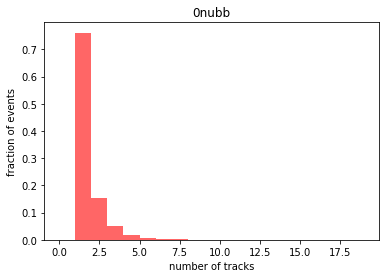

In [22]:
#Check the number of tracks with numb_of_tracks
ntracks_0nubb = tracks_0nubb_1trackfid.numb_of_tracks
maxtracks_0nubb = np.amax(ntracks_0nubb)

plt.hist(ntracks_0nubb, bins = maxtracks_0nubb, range = (0, maxtracks_0nubb),density=True, alpha=0.6, color='r')
plt.xlabel('number of tracks')
plt.ylabel('fraction of events')
plt.title('0nubb')
plt.show()

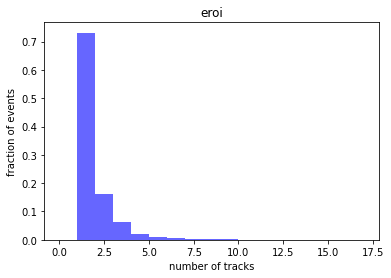

In [23]:
#Check the number of tracks with numb_of_tracks
ntracks_eroi = tracks_selectron_1trackfid.numb_of_tracks
maxtracks_eroi = np.amax(ntracks_eroi)

plt.hist(ntracks_eroi, bins = maxtracks_eroi, range = (0, maxtracks_eroi), density=True, alpha=0.6, color='b')
plt.xlabel('number of tracks')
plt.ylabel('fraction of events')
plt.title('eroi')
plt.show()

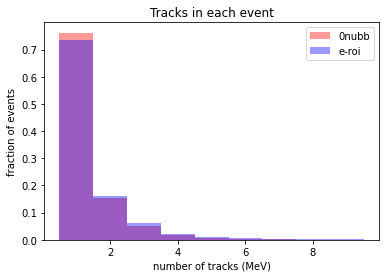

In [24]:
plt.hist(ntracks_0nubb, bins = 9, range = (0.5, 9.5),density=True, alpha=0.4, color='r', label = '0nubb')
plt.hist(ntracks_eroi, bins = 9, range = (0.5, 9.5), density=True, alpha=0.4, color='b',label = 'e-roi')

plt.xlabel('number of tracks (MeV)')
plt.ylabel('fraction of events')
plt.title('Tracks in each event')
plt.legend(loc=1);
plt.show()

In [25]:
print(f'MAX VALUE')
print(f'0nubb')
print(f'- #tracks = {np.amax(ntracks_0nubb)}')
print(f'e-roi')
print(f'- #tracks = {np.amax(ntracks_eroi)}')
print(f'AVG VALUE')
print(f'0nubb')
print(f'- #tracks = {np.average(ntracks_0nubb)}')
print(f'e-roi')
print(f'- #tracks = {np.average(ntracks_eroi)}')

MAX VALUE
0nubb
- #tracks = 19
e-roi
- #tracks = 17
AVG VALUE
0nubb
- #tracks = 1.3934191702432046
e-roi
- #tracks = 1.4879796923995818


In [26]:
tracks_0nubb_track_evt = tracks_0nubb_1track[tracks_0nubb_1track.event == 100]
tracks_0nubb_track_evt.numb_of_tracks

0    1
Name: numb_of_tracks, dtype: int64

In [27]:
tracks_0nubb_1track_cut = tracks_0nubb_1trackfid[tracks_0nubb_1trackfid.numb_of_tracks == 1]
frac_1track_0nubb = 100*tracks_0nubb_1track_cut.event.nunique()/nevents_0nubb_fiducial

Efrac_1track_0nubb = myef.ratio_error(frac_1track_0nubb, tracks_0nubb_1track_cut.event.nunique(), nevents_0nubb_fiducial, 
                                             np.sqrt(tracks_0nubb_1track_cut.event.nunique()), np.sqrt(nevents_0nubb_fiducial))
print(f'Amount of events with 1 track 0nubb = {frac_1track_0nubb} +- {Efrac_1track_0nubb}')

Amount of events with 1 track 0nubb = 76.10872675250357 +- 1.3847426829620102


In [28]:
tracks_selectron_1track_cut = tracks_selectron_1trackfid[tracks_selectron_1trackfid.numb_of_tracks == 1]
frac_1track_selectron = 100*tracks_selectron_1track_cut.event.nunique()/nevents_selectron_fiducial
Efrac_1track_selectron = myef.ratio_error(frac_1track_selectron, tracks_selectron_1track_cut.event.nunique(), nevents_selectron_fiducial, 
                                             np.sqrt(tracks_selectron_1track_cut.event.nunique()), np.sqrt(nevents_selectron_fiducial))
print(f'Amount of events with 1 track eroi = {frac_1track_selectron} +- {Efrac_1track_selectron}')

Amount of events with 1 track eroi = 73.15215768254443 +- 1.3752681165483867


In [29]:
#Checking total amount of events, after fiducial selection

nevents_0nubb_1track = tracks_0nubb_1track.event.nunique()
Enevents_0nubb_1track = np.sqrt(nevents_0nubb_1track)
nevents_0nubb_1trackfid = tracks_0nubb_1trackfid.event.nunique()
Enevents_0nubb_1trackfid = np.sqrt(nevents_0nubb_1trackfid)

nevents_selectron_1track = tracks_selectron_1track.event.nunique()
Enevents_selectron_1track = np.sqrt(nevents_selectron_1track)
nevents_selectron_1trackfid = tracks_selectron_1trackfid.event.nunique()
Enevents_selectron_1trackfid = np.sqrt(nevents_selectron_1trackfid)

ratio_1trackfid_0nubb = 100*nevents_0nubb_1trackfid/nevents_0nubb_fiducial
Eratio_1trackfid_0nubb = myef.ratio_error(ratio_1trackfid_0nubb, nevents_0nubb_1trackfid, nevents_0nubb_fiducial, 
                                             Enevents_0nubb_1trackfid, Enevents_0nubb_fiducial)

eff_1trackfid_0nubb = 100*nevents_0nubb_1trackfid/nevents_0nubb_total
Eeff_1trackfid_0nubb = myef.ratio_error(eff_1trackfid_0nubb, nevents_0nubb_1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_1trackfid, Enevents_0nubb_total)

ratio_1trackfid_selectron = 100*nevents_selectron_1trackfid/nevents_selectron_fiducial
Eratio_1trackfid_selectron = myef.ratio_error(ratio_1trackfid_0nubb, nevents_selectron_1trackfid, nevents_selectron_fiducial, 
                                             Enevents_selectron_1trackfid, Enevents_selectron_fiducial)

eff_1trackfid_selectron = 100*nevents_selectron_1trackfid/nevents_selectron_total
Eeff_1trackfid_selectron = myef.ratio_error(eff_1trackfid_selectron, nevents_selectron_1trackfid, nevents_selectron_total, 
                                             Enevents_selectron_1trackfid, Enevents_selectron_total)

print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')

print('--------!--------------!----------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')


--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9799        
FIDUCIAL   6990                ---      71.33380957240534 +- 1.116807613408483%
1TRACK.    6990        100.0+- 1.6915171678234568% 71.33380957240534 +- 1.116807613408483%
--------!--------------!----------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9767        
FIDUCIAL   6697                ---      68.5676256783045 +- 1.0878425618801453%
1TRACK.    6697        100.0+- 1.7281237878667235% 68.5676256783045 +- 1.0878425618801453%
--------!--------------!----------------!----------------


## 3 - No overlap

In [30]:
#Getting ovlp variable of the tracks, and selecting events with no ovlp

tracks_0nubb_ovlp = tracks_0nubb[tracks_0nubb.ovlp_blob_energy == 0.]
tracks_0nubb_ovlp1trackfid = tracks_0nubb_1trackfid[tracks_0nubb_1trackfid.ovlp_blob_energy == 0.]

tracks_selectron_ovlp = tracks_selectron[tracks_selectron.ovlp_blob_energy == 0.]
tracks_selectron_ovlp1trackfid = tracks_selectron_1trackfid[tracks_selectron_1trackfid.ovlp_blob_energy == 0.]

In [31]:
#Checking total amount of events, after overlap selection

nevents_0nubb_ovlp = tracks_0nubb_ovlp.event.nunique()
Enevents_0nubb_ovlp = np.sqrt(nevents_0nubb_ovlp)
nevents_0nubb_ovlp1trackfid = tracks_0nubb_ovlp1trackfid.event.nunique()
Enevents_0nubb_ovlp1trackfid = np.sqrt(nevents_0nubb_ovlp1trackfid)

nevents_selectron_ovlp = tracks_selectron_ovlp.event.nunique()
Enevents_selectron_ovlp = np.sqrt(nevents_selectron_ovlp)
nevents_selectron_ovlp1trackfid = tracks_selectron_ovlp1trackfid.event.nunique()
Enevents_selectron_ovlp1trackfid = np.sqrt(nevents_selectron_ovlp1trackfid)

ratio_ovlp1trackfid_0nubb = 100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_1trackfid
Eratio_ovlp1trackfid_0nubb = myef.ratio_error(ratio_ovlp1trackfid_0nubb, nevents_0nubb_ovlp1trackfid, nevents_0nubb_1trackfid, 
                                             Enevents_0nubb_ovlp1trackfid, Enevents_0nubb_1trackfid)

eff_ovlp1trackfid_0nubb = 100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_total
Eeff_ovlp1trackfid_0nubb = myef.ratio_error(eff_ovlp1trackfid_0nubb, nevents_0nubb_ovlp1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_ovlp1trackfid, Enevents_0nubb_total)

ratio_ovlp1trackfid_selectron = 100*nevents_selectron_ovlp1trackfid/nevents_selectron_1trackfid
Eratio_ovlp1trackfid_selectron = myef.ratio_error(ratio_ovlp1trackfid_selectron, nevents_selectron_ovlp1trackfid, nevents_selectron_1trackfid, 
                                             Enevents_selectron_ovlp1trackfid, Enevents_selectron_1trackfid)

eff_ovlp1trackfid_selectron = 100*nevents_selectron_ovlp1trackfid/nevents_selectron_total
Eeff_ovlp1trackfid_selectron = myef.ratio_error(eff_ovlp1trackfid_selectron, nevents_selectron_ovlp1trackfid, nevents_selectron_total,
                                             Enevents_selectron_ovlp1trackfid, Enevents_selectron_total)
print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')
print(f'OVLP       {nevents_0nubb_ovlp1trackfid}        {ratio_ovlp1trackfid_0nubb}+- {Eratio_ovlp1trackfid_0nubb}%   {eff_ovlp1trackfid_0nubb} +- {Eeff_ovlp1trackfid_0nubb}%')
print('--------!--------------!----------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print(f'OVLP       {nevents_selectron_ovlp1trackfid}        {ratio_ovlp1trackfid_selectron}+- {Eratio_ovlp1trackfid_selectron}%   {eff_ovlp1trackfid_selectron} +- {Eeff_ovlp1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')



--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9799        
FIDUCIAL   6990                ---      71.33380957240534 +- 1.116807613408483%
1TRACK.    6990        100.0+- 1.6915171678234568% 71.33380957240534 +- 1.116807613408483%
OVLP       6031        86.28040057224607+- 1.516355636965976%   61.54709664251454 +- 1.007308468639272%
--------!--------------!----------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9767        
FIDUCIAL   6697                ---      68.5676256783045 +- 1.0878425618801453%
1TRACK.    6697        100.0+- 1.7281237878667235% 68.5676256783045 +- 1.0878425618801453%
OVLP       6371        95.13214872330894+- 1.6648990942498125%   65.2298556363264 +- 1.0504777945308303%
--------!--------------!----------------!----------------


## 4 - ROI events

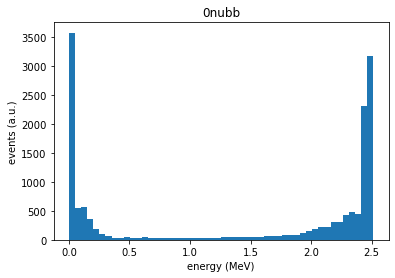

In [32]:
#Getting energy of the tracks
energy_0nubb = tracks_0nubb.energy

plt.hist(energy_0nubb, bins = 50)
plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.show()

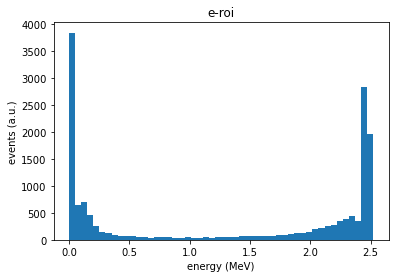

In [33]:
#Getting energy of the tracks
energy_selectron = tracks_selectron.energy

plt.hist(energy_selectron, bins = 50)
plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.show()

In [34]:
#Check limits of the Energy ROI 

emin = 2.40
emax = 2.54

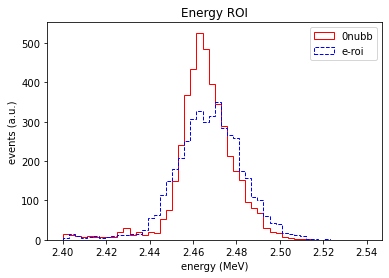

In [35]:
#Selecting events in the ROI
tracks_0nubb_ROI = tracks_0nubb[(tracks_0nubb.energy >= emin) & (tracks_0nubb.energy <= emax)]
tracks_0nubb_ROIovlp1trackfid = tracks_0nubb_ovlp1trackfid[(tracks_0nubb_ovlp1trackfid.energy >= emin) & (tracks_0nubb_ovlp1trackfid.energy <= emax)]

tracks_selectron_ROI = tracks_selectron[(tracks_selectron.energy >= emin) & (tracks_selectron.energy <= emax)]
tracks_selectron_ROIovlp1trackfid = tracks_selectron_ovlp1trackfid[(tracks_selectron_ovlp1trackfid.energy >= emin) & (tracks_selectron_ovlp1trackfid.energy <= emax)]


energy_0nubb = tracks_0nubb_ROIovlp1trackfid.energy
energy_selectron = tracks_selectron_ROIovlp1trackfid.energy

plt.hist(energy_0nubb, bins = 50, range = (emin, emax), color='red', histtype='step', label = '0nubb')
plt.hist(energy_selectron, bins = 50, range = (emin, emax), color='blue', histtype='step', label = 'e-roi', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Energy ROI')
plt.legend(loc=1);
plt.show()

In [36]:
#Checking total amount of events, after ROI selection
nevents_0nubb_ROI = tracks_0nubb_ROI.event.nunique()
Enevents_0nubb_ROI = np.sqrt(nevents_0nubb_ROI)
nevents_0nubb_ROIovlp1trackfid = tracks_0nubb_ROIovlp1trackfid.event.nunique()
Enevents_0nubb_ROIovlp1trackfid = np.sqrt(nevents_0nubb_ROIovlp1trackfid)

nevents_selectron_ROI = tracks_selectron_ROI.event.nunique()
Enevents_selectron_ROI = np.sqrt(nevents_selectron_ROI)
nevents_selectron_ROIovlp1trackfid = tracks_selectron_ROIovlp1trackfid.event.nunique()
Enevents_selectron_ROIovlp1trackfid = np.sqrt(nevents_selectron_ROIovlp1trackfid)


ratio_ROIovlp1trackfid_0nubb = 100*nevents_0nubb_ROIovlp1trackfid/nevents_0nubb_ovlp1trackfid
Eratio_ROIovlp1trackfid_0nubb = myef.ratio_error(ratio_ROIovlp1trackfid_0nubb, nevents_0nubb_ROIovlp1trackfid, nevents_0nubb_ovlp1trackfid, 
                                             Enevents_0nubb_ROIovlp1trackfid, Enevents_0nubb_ovlp1trackfid)

eff_ROIovlp1trackfid_0nubb = 100*nevents_0nubb_ROIovlp1trackfid/nevents_0nubb_total
Eeff_ROIovlp1trackfid_0nubb = myef.ratio_error(eff_ROIovlp1trackfid_0nubb, nevents_0nubb_ROIovlp1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_ROIovlp1trackfid, Enevents_0nubb_total)

ratio_ROIovlp1trackfid_selectron = 100*nevents_selectron_ROIovlp1trackfid/nevents_selectron_ovlp1trackfid
Eratio_ROIovlp1trackfid_selectron = myef.ratio_error(ratio_ROIovlp1trackfid_selectron, nevents_selectron_ROIovlp1trackfid, nevents_selectron_ovlp1trackfid, 
                                             Enevents_selectron_ROIovlp1trackfid, Enevents_selectron_ovlp1trackfid)

eff_ROIovlp1trackfid_selectron = 100*nevents_selectron_ROIovlp1trackfid/nevents_selectron_total
Eeff_ROIovlp1trackfid_selectron = myef.ratio_error(eff_ROIovlp1trackfid_selectron, nevents_selectron_ROIovlp1trackfid, nevents_selectron_total,
                                                   Enevents_selectron_ROIovlp1trackfid, Enevents_selectron_total)
    
print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')
print(f'OVLP       {nevents_0nubb_ovlp1trackfid}        {ratio_ovlp1trackfid_0nubb}+- {Eratio_ovlp1trackfid_0nubb}%   {eff_ovlp1trackfid_0nubb} +- {Eeff_ovlp1trackfid_0nubb}%')
print(f'ROI        {nevents_0nubb_ROIovlp1trackfid}        {ratio_ROIovlp1trackfid_0nubb}+- {Eratio_ROIovlp1trackfid_0nubb}%   {eff_ROIovlp1trackfid_0nubb} +- {Eeff_ROIovlp1trackfid_0nubb}%')
print('--------!--------------!----------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print(f'OVLP       {nevents_selectron_ovlp1trackfid}        {ratio_ovlp1trackfid_selectron}+- {Eratio_ovlp1trackfid_selectron}%   {eff_ovlp1trackfid_selectron} +- {Eeff_ovlp1trackfid_selectron}%')
print(f'ROI        {nevents_selectron_ROIovlp1trackfid}        {ratio_ROIovlp1trackfid_selectron}+- {Eratio_ROIovlp1trackfid_selectron}%   {eff_ROIovlp1trackfid_selectron} +- {Eeff_ROIovlp1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')

--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9799        
FIDUCIAL   6990                ---      71.33380957240534 +- 1.116807613408483%
1TRACK.    6990        100.0+- 1.6915171678234568% 71.33380957240534 +- 1.116807613408483%
OVLP       6031        86.28040057224607+- 1.516355636965976%   61.54709664251454 +- 1.007308468639272%
ROI        4454        73.85176587630575+- 1.4590673225088717%   45.453617716093476 +- 0.8214017284986569%
--------!--------------!----------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9767        
FIDUCIAL   6697                ---      68.5676256783045 +- 1.0878425618801453%
1TRACK.    6697        100.0+- 1.7281237878667235% 68.5676256783045 +- 1.0878425618801453%
OVLP       6371        95.13214872330894+- 1.6648990942498125%   65.2298556363264 +- 1.0504777945308303%
ROI 

## Blob Assignation

In [37]:
#0nubb files
true_list_0nubb, deco_list_0nubb = [],[]
filepath_0nubb_true = filepath+'0nubb/hits/'

#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb_true = filepath_0nubb_true+f'next100.0nubb.{nfile}.deconv.h5'

    try:
        readfile_true_0nubb = pd.read_hdf(filename_0nubb_true, 'MC/particles')
    except:
        print('File {} not good'.format(filename_0nubb_true))
        continue
        
    true_list_0nubb.append(readfile_true_0nubb)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_0nubb = pd.concat([dt for dt in true_list_0nubb]) 
true_0nubb.columns  

Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

In [38]:
#0nubb files
deco_list_0nubb = []

filepath_0nubb_deco = filepath+f'0nubb/hits/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb = filepath_0nubb_deco+f'next100.0nubb.{nfile}.deconv.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_deco = pd.read_hdf(filename_0nubb, 'DECO/Events')
    except:
        print('File {} not good'.format(filename_0nubb))
        continue
        
    deco_list_0nubb.append(readfile_deco)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

deco_0nubb = pd.concat([dt for dt in deco_list_0nubb]) 
deco_0nubb.columns  

File /Users/halmamol/NEXT/files/NEXT100/beershebaFS/0nubb/hits/next100.0nubb.723.deconv.h5 not good
File /Users/halmamol/NEXT/files/NEXT100/beershebaFS/0nubb/hits/next100.0nubb.724.deconv.h5 not good
File /Users/halmamol/NEXT/files/NEXT100/beershebaFS/0nubb/hits/next100.0nubb.754.deconv.h5 not good
File /Users/halmamol/NEXT/files/NEXT100/beershebaFS/0nubb/hits/next100.0nubb.764.deconv.h5 not good
File /Users/halmamol/NEXT/files/NEXT100/beershebaFS/0nubb/hits/next100.0nubb.774.deconv.h5 not good


Index(['event', 'npeak', 'X', 'Y', 'Z', 'E'], dtype='object')

In [39]:
true_0nubb_primary = true_0nubb[true_0nubb.primary == True]
true_0nubb_primary_part1 = true_0nubb_primary[true_0nubb_primary.particle_id == 1]
true_0nubb_primary_part2 = true_0nubb_primary[true_0nubb_primary.particle_id == 2]
true_0nubb_event0 = true_0nubb[true_0nubb.event_id == 0]
true_0nubb_event0

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,0,14743383,gamma,False,2,-198.271820,-256.607605,311.145691,0.218630,-198.084488,...,0.003226,-0.001909,-0.001354,0.0,-0.0,-0.0,0.003986,0.231452,eBrem,phot
1,0,14854918,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084457,...,0.006188,0.003036,0.001210,-0.0,0.0,0.0,0.000048,0.000024,phot,Scintillation
2,0,14854917,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084488,...,-0.001329,0.006434,0.002097,-0.0,-0.0,-0.0,0.000047,0.000050,phot,Scintillation
3,0,14854916,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084488,...,-0.000592,-0.006582,-0.001970,0.0,0.0,0.0,0.000047,0.000024,phot,Scintillation
4,0,14854915,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084656,...,-0.015960,0.015451,0.008377,-0.0,-0.0,-0.0,0.000551,0.000985,phot,Scintillation
5,0,14854914,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084427,...,0.007276,0.001941,0.010619,0.0,0.0,0.0,0.000166,0.000317,phot,Scintillation
6,0,14854913,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.085205,...,-0.038018,-0.038454,-0.014558,0.0,0.0,0.0,0.003059,0.013139,phot,Scintillation
7,0,29046889,e-,False,2,-196.871140,-288.876251,321.973602,0.430943,-197.021393,...,-0.211537,-0.017156,0.079031,-0.0,0.0,0.0,0.047936,1.375517,eIoni,Scintillation
8,0,56290415,e-,False,2,-199.225845,-347.134033,334.436646,0.793654,-199.606995,...,0.204526,0.016255,-0.331930,0.0,-0.0,-0.0,0.131957,5.372118,eIoni,Scintillation
9,0,2,e-,True,0,-239.914810,-238.046280,316.365936,0.000000,-200.825760,...,2.549860,0.109969,0.684162,0.0,0.0,-0.0,2.180298,235.106247,none,Scintillation


In [40]:
def blobassignation_closestPaola(true_info, deco_info, reco_info, tag):
    radius = 21 #mm
    diff_b1_x, diff_b1_y, diff_b1_z = [], [], []
    diff_b2_x, diff_b2_y, diff_b2_z = [], [], []
    
    ehitsblob1, ehitsblob2 = [], []
    diff1_x, diff1_y, diff1_z = [], [], []
    diff2_x, diff2_y, diff2_z = [], [], []
    reco1_x, reco1_y, reco1_z = [], [], []
    reco2_x, reco2_y, reco2_z = [], [], []
    true1_x, true1_y, true1_z = [], [], []
    true2_x, true2_y, true2_z = [], [], []
    reco_blob1, reco_blob2 = [], []

    #[0] e_reco, [1] e_blob1, [2] e_blob2
    reco_e, reco_e_track, reco_e_blob1, reco_e_blob2, reco_e_event = [], [], [], [], []

    totalevents, events12AB, events12BA, eventsNA = 0, 0, 0, 0

    direction12, direction21 = False, False

    for nevt in range(1,true_info.event_id.nunique()):
        print(f'Entered in the loop - event = {nevt}')
        if nevt not in reco_info.event.unique():
            continue
        if nevt not in true_info.event_id.unique():
            continue
        
        primary = true_info[(true_info.event_id == nevt) &
                                               (true_info.primary == True)]
        
        the_hits = deco_0nubb[deco_0nubb.event == nevt]
        
        reco_e_track.append(float(reco_info[reco_info.event == nevt].energy.values))
        reco_e_event.append(nevt)
        
        extreme1 = np.array([primary.final_x.values, primary.final_y.values, primary.final_z.values])
        extreme2 = np.array([primary.initial_x.values, primary.initial_y.values, primary.initial_z.values])       
        
        hit_pos = np.array([the_hits.X.values, the_hits.Y.values, the_hits.Z.values]).transpose()
        hit_e   = the_hits.E
    
        dist1 = scidist.cdist(extreme1.transpose(), hit_pos)
        dist2 = scidist.cdist(extreme2.transpose(), hit_pos)
        
        in_blob1 = dist1 < radius
        in_blob2 = dist2 < radius
        
        reco_blob1.append(reco_info.eblob1)
        reco_blob2.append(reco_info.eblob2)
        
        diff1_x.append(reco_info.blob1_x.values[0] - extreme1.transpose()[0][0])
        diff1_y.append(reco_info.blob1_y.values[0] - extreme1.transpose()[0][1])
        diff1_z.append(reco_info.blob1_z.values[0] - extreme1.transpose()[0][2])
    
        diff2_x.append(reco_info.blob2_x.values[0] - extreme2.transpose()[0][0])
        diff2_y.append(reco_info.blob2_y.values[0] - extreme2.transpose()[0][1])
        diff2_z.append(reco_info.blob2_z.values[0] - extreme2.transpose()[0][2])
        
        reco1_x.append(reco_info.blob1_x.values[0])
        reco1_y.append(reco_info.blob1_y.values[0])
        reco1_z.append(reco_info.blob1_z.values[0])
        reco2_x.append(reco_info.blob2_x.values[0])
        reco2_y.append(reco_info.blob2_y.values[0])
        reco2_z.append(reco_info.blob2_z.values[0])
        
        true1_x.append(extreme1.transpose()[0][0])
        true1_y.append(extreme1.transpose()[0][1])
        true1_z.append(extreme1.transpose()[0][2])
        true2_x.append(extreme2.transpose()[0][0])
        true2_y.append(extreme2.transpose()[0][1])
        true2_z.append(extreme2.transpose()[0][2])
        

    reco_e_blob1 = np.array(reco_blob1)
    reco_e_blob2 = np.array(reco_blob2)

    diff_b1_x = np.array(diff1_x)
    diff_b2_x = np.array(diff2_x)
    diff_b1_y = np.array(diff1_y)
    diff_b2_y = np.array(diff2_y)

    reco1_x = np.array(reco1_x)
    reco2_x = np.array(reco2_x)
    reco1_y = np.array(reco1_y)
    reco2_y = np.array(reco2_y)

    true1_x = np.array(true1_x)
    true2_x = np.array(true2_x)
    true1_y = np.array(true1_y)
    true2_y = np.array(true2_y)
    
    
    reco_e_blob1 = np.array(reco_e_blob1, dtype=np.float)
    reco_e_blob2 = np.array(reco_e_blob2, dtype=np.float)
    reco_e_track = np.array(reco_e_track, dtype=np.float)
    reco_e_event = np.array(reco_e_event, dtype=np.float)

    reco_e.append(reco_e_track)
    reco_e.append(reco_e_blob1)
    reco_e.append(reco_e_blob2)
    reco_e.append(reco_e_event)
    
    return diff_b1_x, diff_b1_y, diff_b2_x, diff_b2_y, reco_e

In [48]:
diff_b1_x_0nubb, diff_b1_y_0nubb, diff_b1_z_0nubb = [], [], []
diff_b2_x_0nubb, diff_b2_y_0nubb, diff_b2_z_0nubb = [], [], []

reco_0nubb_e = []

diff_b1_x_0nubb, diff_b1_y_0nubb, diff_b2_x_0nubb, diff_b2_y_0nubb, reco_0nubb_e = myrvt.blobassignation(true_0nubb, tracks_0nubb_ROIovlp1trackfid, 'signal')


Total events = 4365
Events 12 = 2194 (50.26345933562428%)
Events 21 = 2171 (49.73654066437572%)
Events NA = 0 (0.0%)


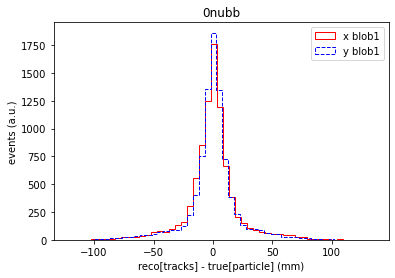

In [49]:
plt.hist(diff_b1_x_0nubb, bins = 50, color='red', histtype='step', label = 'x blob1')
plt.hist(diff_b1_y_0nubb, bins = 50, color='blue', histtype='step', label = 'y blob1', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

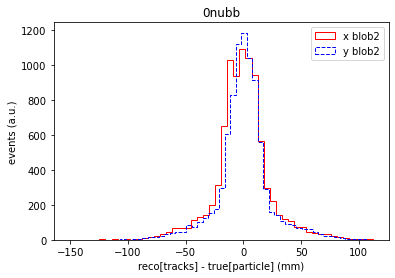

In [50]:
plt.hist(diff_b2_x_0nubb, bins = 50, color='red', histtype='step', label = 'x blob2')
plt.hist(diff_b2_y_0nubb, bins = 50, color='blue', histtype='step', label = 'y blob2', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

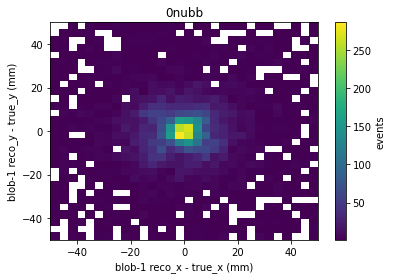

In [51]:
plt.hist2d(diff_b1_x_0nubb, diff_b1_y_0nubb, bins=(30, 30), range=((-50, 50), (-50, 50)), cmap='viridis', cmin=0.001)
plt.xlabel('blob-1 reco_x - true_x (mm)')
plt.ylabel('blob-1 reco_y - true_y (mm)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='events')

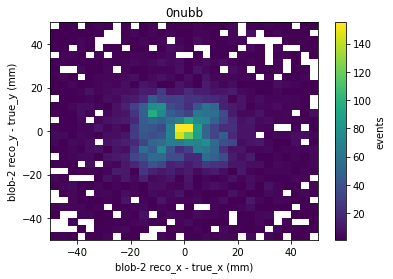

In [52]:
plt.hist2d(diff_b2_x_0nubb, diff_b2_y_0nubb, bins=(30, 30), range=((-50, 50), (-50, 50)), cmap='viridis', cmin=0.001)
plt.xlabel('blob-2 reco_x - true_x (mm)')
plt.ylabel('blob-2 reco_y - true_y (mm)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='events')

In [40]:
#single electron files
true_list_selectron = []
filepath_selectron_true = filepath+'e-_roi/hits/'

#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_selectron_true = filepath_selectron_true+f'next100.e-_roi.{nfile}.deconv.h5'

    try:
        readfile_true_selectron = pd.read_hdf(filename_selectron_true, 'MC/particles')
    except:
        print('File {} not good'.format(filename_selectron_true))
        continue
        
    true_list_selectron.append(readfile_true_selectron)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_selectron = pd.concat([dt for dt in true_list_selectron]) 
true_selectron.columns  

Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

In [41]:
true_selectron_primary = true_selectron[true_selectron.primary == True]

true_selectron_primary_part1 = true_selectron_primary[true_selectron_primary.particle_id == 1]
true_selectron_primary_part2 = true_selectron_primary[true_selectron_primary.particle_id == 2]

In [42]:
diff_b1_x_selectron, diff_b1_y_selectron, diff_b1_z_selectron = [], [], []
diff_b2_x_selectron, diff_b2_y_selectron, diff_b2_z_selectron = [], [], []

reco_selectron_e = []

diff_b1_x_selectron, diff_b1_y_selectron, diff_b2_x_selectron, diff_b2_y_selectron, reco_selectron_e = myrvt.blobassignation(true_selectron, tracks_selectron_ROIovlp1trackfid, 'bkg')

Total events = 4224
Events 12 = 420 (9.943181818181818%)
Events 21 = 3804 (90.05681818181819%)
Events NA = 0 (0.0%)


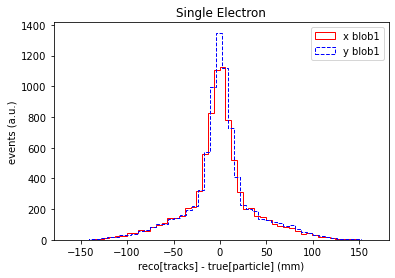

0.14350114890539725

In [43]:
plt.hist(diff_b1_x_selectron, bins = 50, color='red', histtype='step', label = 'x blob1')
plt.hist(diff_b1_y_selectron, bins = 50, color='blue', histtype='step', label = 'y blob1', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()
(np.mean(diff_b1_x_selectron)+np.mean(diff_b1_y_selectron))/2

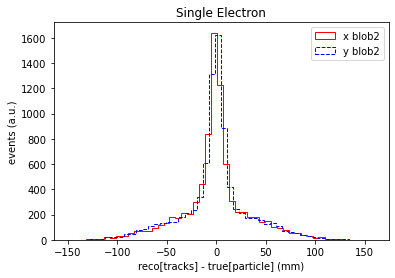

-0.7098693545382146

In [49]:
plt.hist(diff_b2_x_selectron, bins = 50, color='red', histtype='step', label = 'x blob2')
plt.hist(diff_b2_y_selectron, bins = 50, color='blue', histtype='step', label = 'y blob2', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

(np.mean(diff_b2_x_selectron)+np.mean(diff_b2_y_selectron))/2

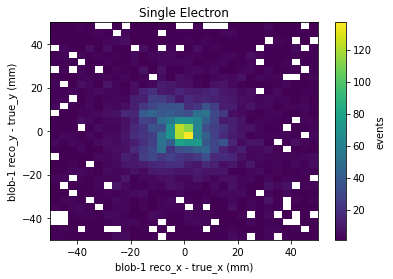

In [45]:
plt.hist2d(diff_b1_x_selectron, diff_b1_y_selectron, bins=(30, 30), range=((-50, 50), (-50, 50)), cmap='viridis', cmin=0.001)
plt.xlabel('blob-1 reco_x - true_x (mm)')
plt.ylabel('blob-1 reco_y - true_y (mm)')
plt.title('Single Electron')
#plt.xlim((0.0,1.5))
plt.colorbar(label='events')

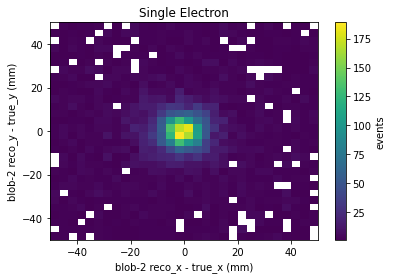

In [46]:
plt.hist2d(diff_b2_x_selectron, diff_b2_y_selectron, bins=(30, 30), range=((-50, 50), (-50, 50)), cmap='viridis', cmin=0.001)
plt.xlabel('blob-2 reco_x - true_x (mm)')
plt.ylabel('blob-2 reco_y - true_y (mm)')
plt.title('Single Electron')
#plt.xlim((0.0,1.5))
plt.colorbar(label='events')

In [48]:
npz_file = '/Users/halmamol/NEXT/NBarrays/recovstrue_FULLSIM_tb'
np.savez(npz_file, diff_b1_x_0nubb=diff_b1_x_0nubb, diff_b1_y_0nubb=diff_b1_y_0nubb, diff_b1_z_0nubb=diff_b1_z_0nubb,
          diff_b2_x_0nubb=diff_b2_x_0nubb, diff_b2_y_0nubb=diff_b2_y_0nubb, diff_b2_z_0nubb=diff_b2_z_0nubb,
         diff_b1_x_selectron=diff_b1_x_selectron, diff_b1_y_selectron=diff_b1_y_selectron, diff_b1_z_selectron=diff_b1_z_selectron,
         diff_b2_x_selectron=diff_b2_x_selectron, diff_b2_y_selectron=diff_b2_y_selectron, diff_b2_z_selectron=diff_b2_z_selectron)


## Check skel values

In [53]:
tracks_0nubb_ROIovlp1trackfid

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,2.475813,183.394771,837,30521,1,-260.5,-369.5,310.205250,...,337.725232,-239.038462,-237.934783,316.151619,0.740607,0.473045,0.0,4.888889,4.903226,4.682453
0,2,0,2.445390,109.413607,892,30547,1,96.5,-146.5,784.210875,...,822.507895,144.375000,-129.166667,790.326980,0.620332,0.534821,0.0,4.842105,4.666667,4.628229
0,4,0,2.489506,130.117362,915,31911,1,-453.5,-79.5,641.252813,...,649.386413,-418.800000,-58.062500,706.292077,0.650352,0.632028,0.0,4.666667,4.733333,4.915485
0,6,0,2.477250,124.884078,820,30546,1,20.5,-416.5,825.211250,...,888.536990,32.909091,-379.350000,831.376995,0.882183,0.443271,0.0,4.882353,4.875000,4.900092
0,7,0,2.463079,133.159004,860,30028,1,-306.5,150.5,404.103688,...,471.442373,-298.166667,168.000000,407.008627,0.923006,0.145184,0.0,4.750000,4.842105,4.841816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,9967,0,2.455584,106.038099,797,29876,1,213.5,-212.5,473.238688,...,530.624842,241.000000,-166.833333,479.329049,0.627861,0.539119,0.0,4.823529,5.000000,4.673143
0,9968,0,2.468272,110.020762,699,25560,1,-185.5,-71.5,204.451219,...,223.926988,-155.269231,-15.812500,227.932434,0.847896,0.701455,0.0,4.947368,4.857143,4.385363
0,9970,0,2.469461,90.904116,897,30190,1,-292.5,-1.5,1024.213125,...,1039.834541,-271.000000,9.714286,1072.888482,0.723023,0.438821,0.0,4.666667,4.727273,4.683063
0,9973,0,2.485147,107.602833,721,28856,1,2.5,-460.5,794.134437,...,829.549634,18.923077,-428.071429,810.160705,0.738507,0.555913,0.0,5.000000,5.000000,4.625368


### SIGNAL EVENTS

In [ ]:
reco_0nubb_e = []

reco_0nubb_e = myrvt.blobassignation_notrue(tracks_0nubb, tracks_0nubb_ROIovlp1trackfid)

In [ ]:
len(reco_0nubb_e[0])

In [ ]:
plt.hist(reco_0nubb_e[1], bins = 50, range = (0, 2.55), color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_0nubb_e[2], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

In [ ]:
weights = myhf.get_weights(reco_0nubb_e[1], True)

plt.hist2d(reco_0nubb_e[1], reco_0nubb_e[2], weights= weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob-1 candidate energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

### BACKGROUND EVENTS

In [ ]:
reco_selectron_e = []

reco_selectron_e = myrvt.blobassignation_notrue(tracks_selectron, tracks_selectron_ROIovlp1trackfid)

In [ ]:
plt.hist(reco_selectron_e[1], bins = 50, range = (0, 2.55),color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_selectron_e[2], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

In [ ]:
weights = myhf.get_weights(reco_selectron_e[1], True)

plt.hist2d(reco_selectron_e[1], reco_selectron_e[2], weights=weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob candidate 1 energy (MeV)')
plt.ylabel('Blob candidate 2 energy (MeV)')
plt.title('Single Electron')
plt.colorbar(label='proportion of events')

In [ ]:
weights = myhf.get_weights(reco_0nubb_e[0], True)

plt.hist2d(reco_0nubb_e[0], reco_0nubb_e[2], bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

In [ ]:
weights = myhf.get_weights(reco_0nubb_e[0], True)

plt.hist2d(reco_0nubb_e[0], reco_0nubb_e[1], bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-1 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

## Efficiency Values and FOM Estimation

In [ ]:
plt.hist(reco_0nubb_e[2], bins = 50, histtype='step', label = 'energy track')
plt.xlabel('blob-2 energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.show()

In [ ]:
plt.hist(reco_selectron_e[2], bins = 50, histtype='step', label = 'energy track')
plt.xlabel('blob-2 energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.show()

print(f'Total events {len(reco_selectron_e[0])}')

Since I need to compare both simulations, I'm going to use the same energy cuts. Besides, they seem reasonable looking into the blob2 energy distribution:

In [ ]:
blobcut_energy=[]
#in MeV
minEcut = 0.010
maxEcut = 0.600
stepsEcut = 0.010

#defining the vector with the cut values
blobcut_energy=myef.blobthreshold(minEcut,maxEcut,stepsEcut)

Now I'm going to take the information from reco_selectron_e[][], to see how many events with each cut I get:

In [ ]:
blobcut_energy_nevents_0nubb, blobcut_energy_nevents_selectron = [], [] 

blobcut_energy_nevents_0nubb = myef.nevents_afterthreshold(blobcut_energy, reco_0nubb_e)
blobcut_energy_nevents_selectron = myef.nevents_afterthreshold(blobcut_energy, reco_selectron_e)

blobcut_energy_nevents_0nubb = np.array(blobcut_energy_nevents_0nubb, dtype=np.float)
blobcut_energy_nevents_selectron = np.array(blobcut_energy_nevents_selectron, dtype=np.float)

Create now arrays containing the statistical uncertainty (sqrt from total amount of events)

In [ ]:
blobcut_energy_nevents_0nubb_error, blobcut_energy_nevents_selectron_error= [], []

blobcut_energy_nevents_0nubb_error = myef.sqrterror_array(blobcut_energy_nevents_0nubb)
blobcut_energy_nevents_selectron_error = myef.sqrterror_array(blobcut_energy_nevents_selectron)

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(blobcut_energy,blobcut_energy_nevents_0nubb, yerr=blobcut_energy_nevents_0nubb_error, fmt = '-r')
plt.ylabel('accepted events (a.u.)')
plt.xlabel('blob-2 energy threshold (MeV)')
#plt.title('Cut efficiency')

Now that I have checked the accepted events for each energy cut, I'm going to compute the efficiency/background values:

In [ ]:
fom_error, e_error, b_error = [], [], []

e, b, fom, e_error, b_error, fom_error = myef.efficiencyterms(blobcut_energy_nevents_0nubb, blobcut_energy_nevents_selectron, 
                            blobcut_energy_nevents_0nubb_error, blobcut_energy_nevents_selectron_error,
                            reco_0nubb_e, reco_selectron_e)

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(1-b,e, xerr=b_error, yerr=e_error, fmt = '-r')
plt.ylabel('signal efficiency')
plt.xlabel('background rejection')
#plt.title('Cut efficiency')

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(blobcut_energy,fom, yerr=fom_error,fmt = '-r')
plt.xlabel('blob-2 energy threshold (MeV)')
plt.ylabel('f.o.m.=e/sqrt(b)')
#plt.title('Cut efficiency')

In [ ]:
myef.best_fom(e,b,fom,blobcut_energy)

In [ ]:
npz_file = '/Users/halmamol/NEXT/NBarrays/ntracks_FULLSIM_tb'
np.savez(npz_file, ntracks_0nubb=ntracks_0nubb, ntracks_eroi=ntracks_eroi)

### Testing selected events

In [ ]:
events_noaccept = []
for i in range(len(reco_0nubb_e[2])):
    if reco_0nubb_e[2][i] < 0.46:
        events_noaccept.append(reco_0nubb_e[3][i])
len(events_noaccept)

In [ ]:
base_vsize = 5 #mm
this_evt_df = deco_0nubb[deco_0nubb.event == 6]
the_hits = []

xs = this_evt_df.X
ys = this_evt_df.Y
zs = this_evt_df.Z
es = this_evt_df.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

plt.show()

In [ ]:
this_evt_df

In [ ]:
base_vsize = 5 #mm
this_evt_df = deco_0nubb[deco_0nubb.event == 12]
the_hits = []

xs = this_evt_df.X
ys = this_evt_df.Y
zs = this_evt_df.Z
es = this_evt_df.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

plt.show()

In [ ]:
this_evt_df